In [1]:
import torch
import PIL

import torchvision
import torchvision.transforms as transforms

import torch.optim as optim
import torch.nn as nn

print(f"CUDA available: {torch.cuda.is_available()}")

CUDA available: True


In [2]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))])

In [4]:
trainset = torchvision.datasets.FashionMNIST(root="./data",
                                             train=True,
                                             download=True,
                                             transform=transform)

testset = torchvision.datasets.FashionMNIST(root="./data",
                                            train=False,
                                            download=True,
                                            transform=transform)

100%|██████████| 26421880/26421880 [00:00<00:00, 114797167.27it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 13654851.37it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 65153279.36it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 27057991.22it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress',
           'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [6]:
print(trainset.data.shape)
print(testset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


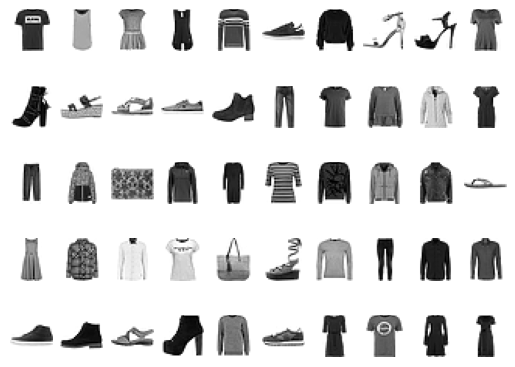

In [7]:
import matplotlib.pyplot as plt

figure = plt.figure()
num_of_images = 50

for index in range(1, num_of_images + 1):
  plt.subplot(5, 10, index)
  plt.axis("off")
  plt.imshow(trainset.data[index], cmap="gray_r")

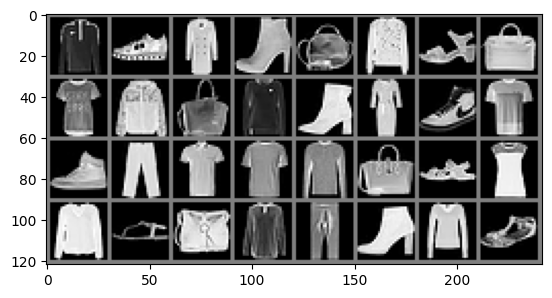

Pullover Sneaker  Coat Ankle boot   Bag Pullover Sandal   Bag


In [11]:
import numpy as np

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(" ".join("%5s" % classes[labels[j]] for j in range(8)))

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64*12*12, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 64*12*12)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [21]:
epochs = 15

epoch_log = []
loss_log = []
accuracy_log = []

for epoch in range(epochs):
  print(f"Starting Epoch: {epoch+1}...")
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i%100 == 99:
      correct = 0
      total = 0

      with torch.no_grad():
        for data in testloader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)

          outputs = net(images)

          _, predicted = torch.max(outputs.data, 1)

          total += labels.size(0)
          correct += (predicted == labels).sum().item()
        accuracy = 100*correct/total
        epoch_num = epoch+1
        actual_loss = running_loss / 50
        print(f"Epoch: {epoch_num}, Mini-Batch Completed: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%")
        running_loss = 0.0
  epoch_log.append(epoch_num)
  loss_log.append(actual_loss)
  accuracy_log.append(accuracy)

print("Finished Training")

Starting Epoch: 1...


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1, Mini-Batch Completed: 100, Loss: 1.338, Test Accuracy = 74.120%
Epoch: 1, Mini-Batch Completed: 200, Loss: 1.316, Test Accuracy = 76.130%
Epoch: 1, Mini-Batch Completed: 300, Loss: 1.238, Test Accuracy = 76.810%
Epoch: 1, Mini-Batch Completed: 400, Loss: 1.225, Test Accuracy = 74.900%
Epoch: 1, Mini-Batch Completed: 500, Loss: 1.147, Test Accuracy = 77.090%
Epoch: 1, Mini-Batch Completed: 600, Loss: 1.120, Test Accuracy = 76.330%
Epoch: 1, Mini-Batch Completed: 700, Loss: 1.101, Test Accuracy = 79.730%
Epoch: 1, Mini-Batch Completed: 800, Loss: 1.070, Test Accuracy = 78.590%
Epoch: 1, Mini-Batch Completed: 900, Loss: 1.043, Test Accuracy = 80.590%
Epoch: 1, Mini-Batch Completed: 1000, Loss: 1.047, Test Accuracy = 80.220%
Epoch: 1, Mini-Batch Completed: 1100, Loss: 1.055, Test Accuracy = 80.450%
Epoch: 1, Mini-Batch Completed: 1200, Loss: 0.978, Test Accuracy = 81.230%
Epoch: 1, Mini-Batch Completed: 1300, Loss: 1.018, Test Accuracy = 81.800%
Epoch: 1, Mini-Batch Completed: 14

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Starting Epoch: 2...
Epoch: 2, Mini-Batch Completed: 100, Loss: 0.909, Test Accuracy = 81.540%
Epoch: 2, Mini-Batch Completed: 200, Loss: 0.898, Test Accuracy = 83.760%
Epoch: 2, Mini-Batch Completed: 300, Loss: 0.872, Test Accuracy = 83.430%
Epoch: 2, Mini-Batch Completed: 400, Loss: 0.877, Test Accuracy = 83.650%
Epoch: 2, Mini-Batch Completed: 500, Loss: 0.831, Test Accuracy = 84.260%
Epoch: 2, Mini-Batch Completed: 600, Loss: 0.827, Test Accuracy = 84.410%
Epoch: 2, Mini-Batch Completed: 700, Loss: 0.857, Test Accuracy = 84.640%
Epoch: 2, Mini-Batch Completed: 800, Loss: 0.817, Test Accuracy = 84.300%
Epoch: 2, Mini-Batch Completed: 900, Loss: 0.825, Test Accuracy = 84.460%
Epoch: 2, Mini-Batch Completed: 1000, Loss: 0.807, Test Accuracy = 84.900%
Epoch: 2, Mini-Batch Completed: 1100, Loss: 0.785, Test Accuracy = 83.770%
Epoch: 2, Mini-Batch Completed: 1200, Loss: 0.774, Test Accuracy = 85.190%
Epoch: 2, Mini-Batch Completed: 1300, Loss: 0.798, Test Accuracy = 85.070%
Epoch: 2, Min

In [24]:
correct = 0
total = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100*correct/total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.4}%')

Accuracy of the network on the 10000 test images: 91.37%


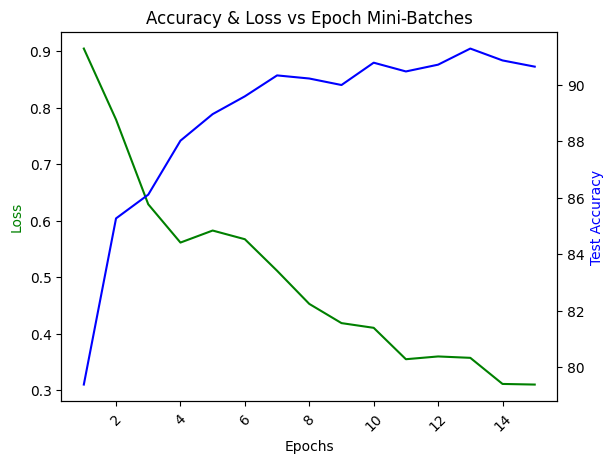

In [25]:
fig, ax1 = plt.subplots()

plt.title("Accuracy & Loss vs Epoch Mini-Batches")
plt.xticks(rotation=45)
ax2 = ax1.twinx()
ax1.plot(epoch_log, loss_log, 'g-')
ax2.plot(epoch_log, accuracy_log, 'b-')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

In [32]:
data_aug_transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), shear=5),
    transforms.ColorJitter(hue=0.05, saturation=0.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Grayscale(num_output_channels=1)
])

In [33]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showAugmentations(image, augmentations = 6):
    fig = figure()
    for i in range(augmentations):
        a = fig.add_subplot(1,augmentations,i+1)
        img = data_aug_transform(image)
        imshow(img ,cmap='Greys_r')
        axis('off')

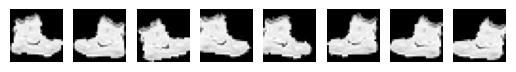

In [34]:
image = trainset.data[0].numpy()
img_pil = PIL.Image.fromarray(image)
showAugmentations(img_pil, 8)